Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.


# LAB9

Write a local-search algorithm (eg. an EA) able to solve the _Problem_ instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

- Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
- Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

- Reviews will be assigned on Monday, December 4
- You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)


In [130]:
from random import choices, choice, random, randint, sample, uniform
from copy import copy
import matplotlib.pyplot as plt

import lab9_lib

## Problem definition


In [131]:
GENOME_LENGTH = 1000
POPULATION_SIZE = 100
OFFSPRING_SIZE = 20
MUTATION_PROBABILITY = 0.1
TOURNAMENT_SIZE = 2
PROBLEM_SIZE = 5
NUM_ISLANDS = 10

In [132]:
def initialize_population():
    return [choices([0, 1], k=GENOME_LENGTH) for _ in range(POPULATION_SIZE)]

In [133]:
fitness = lab9_lib.make_problem(PROBLEM_SIZE)

## Selection, mutation, crossover

I implemented tournment_selection for parent selection;
For crossover I implemented one cut and two point, but ended up using only two point in my test runs;
For mutation I implemented flipping 1 or 2 bits, but as that showed to be innefective for a 1000 loci genome, I implemented and used a mutation that flips a percentage of the genome between 1% and 5%;


In [134]:
def tournament_selection(population):
    return max(
        [choice(population) for _ in range(TOURNAMENT_SIZE)], key=lambda i: fitness(i)
    )


def one_cut_xover(ind1, ind2):
    cut_point = randint(0, GENOME_LENGTH - 1)
    offspring = ind1[:cut_point] + ind2[cut_point:]
    return offspring


def two_point_xover(ind1, ind2):
    pos1 = randint(0, GENOME_LENGTH - 1)
    pos2 = randint(pos1, GENOME_LENGTH - 1)
    offspring = ind1[:pos1] + ind2[pos1:pos2] + ind1[pos2:]
    return offspring


def flip_random_bit(ind):
    offspring = copy(ind)
    pos = randint(0, GENOME_LENGTH - 1)
    offspring[pos] = int(not offspring[pos])
    return offspring


def flip_2_random_bits(ind):
    offspring = copy(ind)
    pos1, pos2 = tuple(choices(range(0, GENOME_LENGTH), k=2))
    offspring[pos1] = int(not ind[pos1])
    offspring[pos2] = int(not ind[pos2])
    return offspring


def flip_random_percentage_of_bits(ind):
    offspring = ind.copy()
    mutation_rate = uniform(*(0.01, 0.05))

    num_flips = int(GENOME_LENGTH * mutation_rate)

    positions_to_flip = sample(range(GENOME_LENGTH), num_flips)

    for pos in positions_to_flip:
        offspring[pos] = 1 - offspring[pos]

    return offspring

## Islands and elitism

I implemented islands to promote population diversity and prevent premature convergence;
I also implemented elitism to ensure that the best-performing individuals are preserved across generations;

The function below performs the exchange of a specified proportion of individuals between islands, while preserving the best individual;


In [135]:
def migration(populations, migration_rate, elite_individuals):
    num_islands = len(populations)
    migrants_per_island = int(POPULATION_SIZE * migration_rate)

    for source_island in range(num_islands):
        destination_island = (source_island + 1) % num_islands
        migrants = populations[source_island][:migrants_per_island]
        populations[destination_island][-migrants_per_island:] = migrants

        migrants_fitness = [fitness(ind) for ind in migrants]

        if elite_individuals[destination_island] is None or max(
            migrants_fitness
        ) > fitness(elite_individuals[destination_island]):
            elite_individuals[destination_island] = copy(
                migrants[migrants_fitness.index(max(migrants_fitness))]
            )

## Evolution strategy

I implemented a $(\lambda, \mu)$ strategy with elitism and parallel islands as shown before.


Island 1, Generation 1, Best Fitness: 0.204526
Island 2, Generation 1, Best Fitness: 0.28649
Island 3, Generation 1, Best Fitness: 0.28937
Island 4, Generation 1, Best Fitness: 0.191356


Island 5, Generation 1, Best Fitness: 0.31623
Island 6, Generation 1, Best Fitness: 0.204471
Island 7, Generation 1, Best Fitness: 0.2927
Island 8, Generation 1, Best Fitness: 0.208143
Island 9, Generation 1, Best Fitness: 0.204906
Island 10, Generation 1, Best Fitness: 0.204704
Island 1, Generation 2, Best Fitness: 0.204704
Island 2, Generation 2, Best Fitness: 0.28649
Island 3, Generation 2, Best Fitness: 0.28937
Island 4, Generation 2, Best Fitness: 0.28937
Island 5, Generation 2, Best Fitness: 0.31623
Island 6, Generation 2, Best Fitness: 0.31623
Island 7, Generation 2, Best Fitness: 0.2927
Island 8, Generation 2, Best Fitness: 0.2927
Island 9, Generation 2, Best Fitness: 0.208143
Island 10, Generation 2, Best Fitness: 0.20872300000000002
Island 1, Generation 3, Best Fitness: 0.20872300000000002
Island 2, Generation 3, Best Fitness: 0.28649
Island 3, Generation 3, Best Fitness: 0.28937
Island 4, Generation 3, Best Fitness: 0.28937
Island 5, Generation 3, Best Fitness: 0.31623
Islan

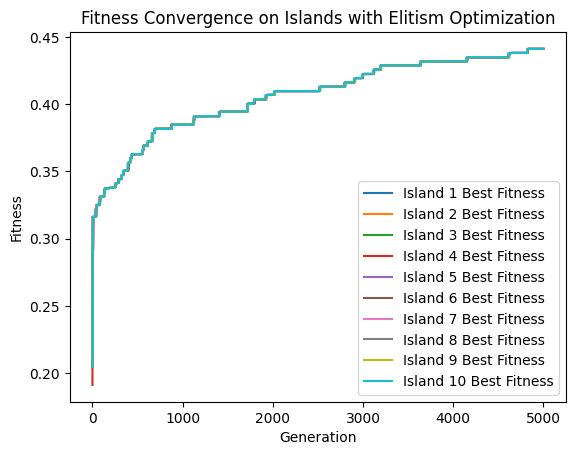

FITNESS CALLS:  8411840


In [136]:
def evolution(
    populations,
    parent_selection,
    crossover,
    mutation,
    generations,
    max_no_improvement,
    migration_rate=0.1,
    elitism_rate=0.1,
):
    num_islands = len(populations)
    best_fitness = [float("-inf")] * num_islands
    elite_individuals = [None] * num_islands
    consecutive_no_improvement = [0] * num_islands
    fitness_history = [[] for _ in range(num_islands)]

    for generation in range(generations):
        for island in range(num_islands):
            population = populations[island]
            offspring = list()

            if elite_individuals[island] is not None:
                offspring.append(elite_individuals[island])

            elitism_count = int(POPULATION_SIZE * elitism_rate)
            elite = population[:elitism_count]
            offspring.extend(elite)

            for _ in range(OFFSPRING_SIZE - len(offspring)):
                if random() < MUTATION_PROBABILITY:
                    p = parent_selection(population)
                    o = mutation(p)
                else:
                    p1 = parent_selection(population)
                    p2 = parent_selection(population)
                    o = crossover(p1, p2)
                offspring.append(o)

            combined_population = population + offspring

            combined_population.sort(key=lambda i: fitness(i), reverse=True)
            populations[island] = combined_population[:POPULATION_SIZE]

            if elite_individuals[island] is None or fitness(
                elite_individuals[island]
            ) < fitness(populations[island][0]):
                elite_individuals[island] = copy(populations[island][0])

            if fitness(populations[island][0]) > best_fitness[island]:
                best_fitness[island] = fitness(populations[island][0])
                consecutive_no_improvement[island] = 0
            else:
                consecutive_no_improvement[island] += 1

            fitness_history[island].append(best_fitness[island])

            print(
                f"Island {island + 1}, Generation {generation + 1}, Best Fitness: {best_fitness[island]}",
                flush=True,
            )

        migration(populations, migration_rate, elite_individuals)

        if all(
            consecutive >= max_no_improvement
            for consecutive in consecutive_no_improvement
        ):
            print(f"Converged at generation {generation + 1}")
            break

    for island in range(num_islands):
        plt.plot(
            range(0, generation + 1),
            fitness_history[island],
            label=f"Island {island + 1} Best Fitness",
        )

    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Convergence on Islands with Elitism Optimization")
    plt.legend()
    plt.show()


populations = [initialize_population() for _ in range(NUM_ISLANDS)]

evolution(
    populations,
    tournament_selection,
    two_point_xover,
    flip_random_percentage_of_bits,
    generations=5000,
    max_no_improvement=500,
    migration_rate=0.1,
    elitism_rate=0.1,
)

print("FITNESS CALLS: ", fitness.calls)